# Analysis of Oscar-nominated Films

In [188]:
import re
import numpy as np
import pandas as pd
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [153]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

sb.set(color_codes=True)
sb.set_palette("muted")

np.random.seed(sum(map(ord, "regression")))

In [182]:
awards = pd.read_csv('../data/nominations.csv')
oscars = pd.read_csv('../data/analysis.csv')

## Descriptive Analysis

To better understand general trends in the data. This is a work in progress. *last updated on: February 26, 2017*

### Seasonality

It is well known that movies gunning for an Academy Award aim to be released between December and February, two months before the award ceremony. This is pretty evident looking at a distribution of film release months:

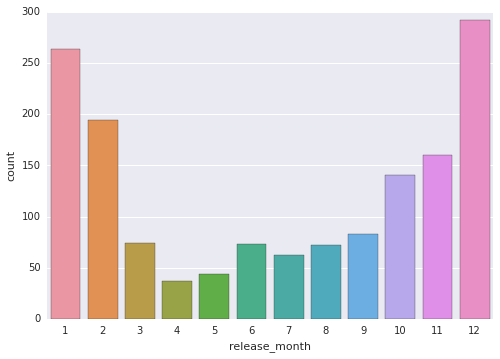

In [175]:
sb.countplot(x="release_month", data=oscars)

This can be more or less confirmed by calculating the Pearson correlation coefficient, which measures the linear dependence between two variables:

In [212]:
def print_pearsonr(data, dependent, independent):
    for field in independent:
        coeff = stats.pearsonr(data[dependent], data[field])
        print "{0} | coeff: {1} | p-value: {2}".format(field, coeff[0], coeff[1])

print_pearsonr(oscars, 'Oscar', ['q1_release', 'q2_release', 'q3_release', 'q4_release'])

q1_release | coeff: 0.0516477112662 | p-value: 0.0457924227928
q2_release | coeff: -0.0315055870144 | p-value: 0.223276479778
q3_release | coeff: 0.00108129557868 | p-value: 0.966668039253
q4_release | coeff: -0.0317501964736 | p-value: 0.219701562299


Q1 and Q4 have a higher coefficient than Q2 and Q3, so that points in the right direction...

This won't really help us determine **who** will win the actual Oscar, but at least we know that if we want a shot, we need to be releasing in late Q4 and early Q1.

### Profitability

How do the financial details contribute to Oscar success? 

In [179]:
# In case we want to examine the data based on the release decade...
oscars['decade'] = oscars['year'].apply(lambda y: str(y)[2] + "0")

In [186]:
# Adding some fields to slice and dice...
profit = oscars[~oscars['budget'].isnull()]
profit = profit[~profit['box_office'].isnull()]

profit['profit'] = profit['box_office'] - profit['budget']
profit['margin'] = profit['profit'] / profit['box_office']

#### Profitability by Award Category

Since 1980, the profitability for films which won an Oscar were on average higher than all films nominated that year. 

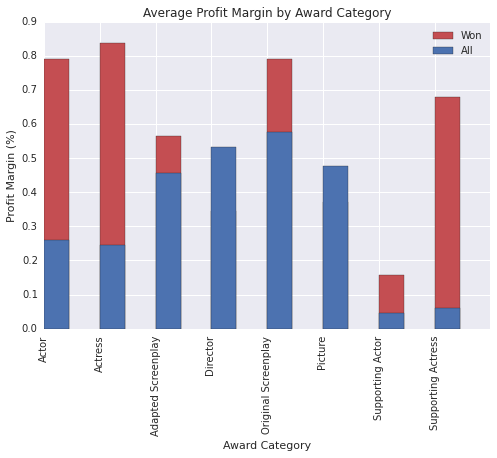

In [187]:
avg_margin_for_all = profit.groupby(['category'])['margin'].mean()
avg_margin_for_win = profit[profit['Oscar'] == 1].groupby(['category'])['margin'].mean()

fig, ax = plt.subplots()

index = np.arange(len(profit['category'].unique()))

rects1 = plt.bar(index, avg_margin_for_win, 0.45, color='r', label='Won')
rects2 = plt.bar(index, avg_margin_for_all, 0.45, color='b', label='All')

plt.xlabel('Award Category')
ax.set_xticklabels(profit['category'].unique(), rotation='vertical')

plt.ylabel('Profit Margin (%)')
plt.title('Average Profit Margin by Award Category')
plt.legend()
plt.show()

##### The biggest losers...that won?

This is just a fun fact. There were 5 awards since 1980 that were given to films that actually *lost* money.

In [82]:
fields = ['year', 'film', 'category', 'name', 'budget', 'box_office', 'profit', 'margin']
profit[(profit['profit'] < 0) & (profit['Oscar'] == 1)][fields]

,year,film,category,name,budget,box_office,profit,margin
218,1994,Blue Sky,Actress,Jessica Lange,16000000.000,3359465.000,-12640535.000,-3.763
394,1998,Gods and Monsters,Adapted Screenplay,Bill Condon,10000000.000,6500000.000,-3500000.000,-0.538
747,2000,Almost Famous,Original Screenplay,Cameron Crowe,60000000.000,47400000.000,-12600000.000,-0.266
1103,1994,Ed Wood,Supporting Actor,Martin Landau,18000000.000,5900000.000,-12100000.000,-2.051
1262,1994,Bullets over Broadway,Supporting Actress,Dianne Wiest,20000000.000,13400000.000,-6600000.000,-0.493


### Other Awards

Do the BAFTAs, Golden Globes, Screen Actors Guild Awards, etc. forecast who is going to win the Oscars? Let's find out...

In [249]:
winning_awards = oscars[['category', 'Oscar', 'BAFTA', 'Golden Globe', 'Guild']]
winning_awards.head()

,category,Oscar,BAFTA,Golden Globe,Guild
0,Actor,1.000,0.000,1.000,0.000
1,Actor,0.000,0.000,0.000,0.000
2,Actor,0.000,1.000,0.000,0.000
3,Actor,0.000,0.000,0.000,0.000
4,Actor,0.000,0.000,0.000,0.000


Pearson correlation for acting categories

BAFTA | coeff: 0.343106753782 | p-value: 1.53555701801e-21
Golden Globe | coeff: 0.471264631568 | p-value: 1.59689509599e-41
Guild | coeff: 0.467345698872 | p-value: 8.92371589745e-41


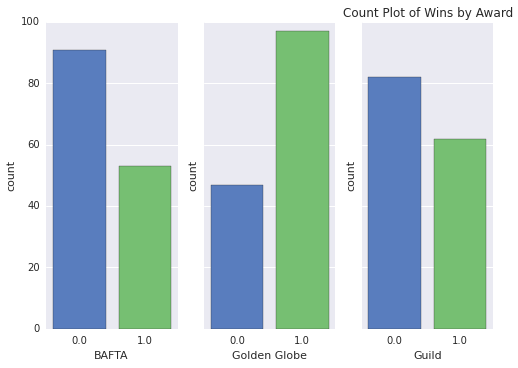

In [244]:
acting_categories = ['Actor', 'Actress', 'Supporting Actor', 'Supporting Actress']
                     
y = winning_awards[(winning_awards['Oscar'] == 1)&(winning_awards['category'].isin(acting_categories))]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)

plt.title('Count Plot of Wins by Award')

sb.countplot(x="BAFTA", data=y, ax=ax1)
sb.countplot(x="Golden Globe", data=y, ax=ax2)
sb.countplot(x="Guild", data=y, ax=ax3)

print "Pearson correlation for acting categories\n"
print_pearsonr(oscars[oscars['category'].isin(acting_categories)], 'Oscar', ['BAFTA', 'Golden Globe', 'Guild'])

It looks like if the Golden Globes and Screen Actors Guild awards are better indicators of Oscar success than the BAFTAs. Let's take a look at the same analysis, but for Best Picture. The "Guild" award we use is the [Screen Actor Guild Award for Outstanding Performance by a Cast in a Motion Picture](https://en.wikipedia.org/wiki/Screen_Actors_Guild_Award_for_Outstanding_Performance_by_a_Cast_in_a_Motion_Picture). 

Pearson correlation for acting categories

BAFTA | coeff: 0.303661894517 | p-value: 5.22830069622e-06
Golden Globe | coeff: 0.367860033304 | p-value: 2.34135839185e-08
Guild | coeff: 0.286173459405 | p-value: 1.8594940365e-05


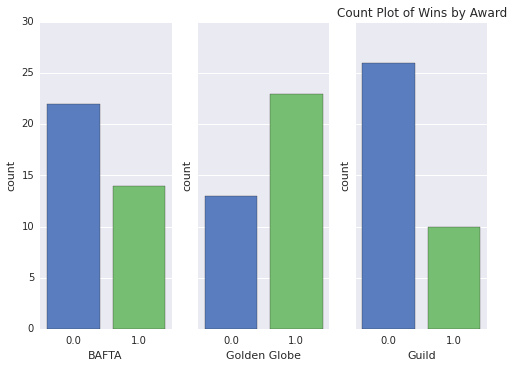

In [247]:
y = winning_awards[(winning_awards['Oscar'] == 1)&(winning_awards['category'] == 'Picture')]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)

plt.title('Count Plot of Wins by Award')

sb.countplot(x="BAFTA", data=y, ax=ax1)
sb.countplot(x="Golden Globe", data=y, ax=ax2)
sb.countplot(x="Guild", data=y, ax=ax3)

print "Pearson correlation for acting categories\n"
print_pearsonr(oscars[oscars['category'] == 'Picture'], 'Oscar', ['BAFTA', 'Golden Globe', 'Guild'])

Seems like the BAFTAs hold a bit more weight than the SAG awar, but the Golden Globes are still the best way to forecast an Oscar win.